##Topic: AutoEncoder
## Author: Atoosa Chegini

## AutoEncoder
An autoencoder has two parts: an **encoder** and a **decoder**.


The encoder reduces the dimensions of input data so that the original information is compressed.
![Encoder](https://miro.medium.com/max/425/1*Dc3WI46OHvgu4c09nU4H4g.png)

The decoder restores the original information from the compressed data.


![Decoder](https://miro.medium.com/max/424/1*CO3-zpukfra4osABDfGc_Q.png)

The autoencoder is a neural network that learns to encode and decode automatically. In this notebook we will learn how to implement a simple autoencoder and will see the application of this kind of Neural Network.

Our dataset here is **[MNIST](http://yann.lecun.com/exdb/mnist/)**, which is a well known database of handwritten digits. Keras has MNIST dataset utility. We can download the data as follows:

In [1]:
import tensorflow as tf
from tensorflow import keras
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


We can see the shape of each image in the dataset by using the code below.

In [2]:
# The ourput is the shape of the image with index zero. (their shapes are all the same!)
X_train[0].shape

(28, 28)

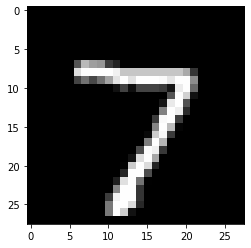

In [5]:
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(np.array(X_test[0], dtype='float').reshape((28, 28)), cmap='gray')
plt.show()

##Simple Autoencoder

We start with a simple autoencoder based on a fully connected layers. One hidden layer handles the encoding, and the output layer handles the decoding.
Each of the input images is flatten to an array of 784 (=28×28) data points. This is then compressed into 32 data points by the fully connected layer.

In [6]:
from tensorflow.keras import layers
inputs  = layers.Input(shape=(784,))           # 28*28 flatten
enc_fc  = layers.Dense( 32, activation='relu') # to 32 data points
encoded = enc_fc(inputs)

Then, we decode the encoded data to the original 784 data points. The sigmoid will return values between 0 and 1 for each pixel (intensity).

In [7]:
dec_fc  = layers.Dense(784, activation='sigmoid') # to 784 data points
decoded = dec_fc(encoded)

This whole processing becomes the trainable autoencoder model.

In [8]:
from keras.models import Model 
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Next, we are going to show you what is the benefit of autoencoders. therefore, We preprocess the MNIST image data so that image data are normalized between 0 and 1.

In [9]:
def preprocess(x):
    x = x.astype('float32') / 255.
    return x.reshape(-1, np.prod(x.shape[1:])) # flatten
X_train = preprocess(X_train)
X_test  = preprocess(X_test)

We also split the train data into a train set and a validation set.

In [10]:
from sklearn.model_selection import train_test_split

# also create a validation set for training
X_train, X_valid = train_test_split(X_train, test_size=500)

We train the autoencoder which compress the input image and then restore to the original size. As such, our training data and label data are both the same image data.

In [11]:
autoencoder.fit(X_train, X_train, # data and label are the same
                epochs=50, 
                batch_size=128, 
                validation_data=(X_valid, X_valid))

Epoch 1/50
465/465 [==============================] - 4s 4ms/step - loss: 0.2286 - val_loss: 0.1623
Epoch 2/50
465/465 [==============================] - 2s 4ms/step - loss: 0.1429 - val_loss: 0.1298
Epoch 3/50
465/465 [==============================] - 2s 4ms/step - loss: 0.1207 - val_loss: 0.1137
Epoch 4/50
465/465 [==============================] - 2s 4ms/step - loss: 0.1091 - val_loss: 0.1051
Epoch 5/50
465/465 [==============================] - 2s 4ms/step - loss: 0.1026 - val_loss: 0.0998
Epoch 6/50
465/465 [==============================] - 2s 4ms/step - loss: 0.0985 - val_loss: 0.0963
Epoch 7/50
465/465 [==============================] - 2s 4ms/step - loss: 0.0963 - val_loss: 0.0948
Epoch 8/50
465/465 [==============================] - 2s 4ms/step - loss: 0.0952 - val_loss: 0.0939
Epoch 9/50
465/465 [==============================] - 2s 4ms/step - loss: 0.0946 - val_loss: 0.0935
Epoch 10/50
465/465 [==============================] - 2s 4ms/step - loss: 0.0943 - val_loss: 0.0932

By training an autoencoder, we are really training both the encoder and the decoder at the same time.

We can build an encoder and use it to compress MNIST digit images.

In [12]:
encoder = Model(inputs, encoded)
X_test_encoded = encoder.predict(X_test)

We can confirm the 784 pixel data points are now compressed into 32 data points.

In [13]:
X_test_encoded[0].shape
# You can see that the data is compressed by using an encoder.

(32,)

Let’s also build a decoder so that we can decompress the compressed image to the original image size. The decoder takes 32 data points as its input (the size of encoded data).

In [14]:
decoder_inputs = layers.Input(shape=(32,))
decoder = Model(decoder_inputs, dec_fc(decoder_inputs))
# decode the encoded test data
X_test_decoded = decoder.predict(X_test_encoded)

In [15]:
X_test_decoded[0].shape
# The shape of each image is now 28*28, which is the same as original images from the dataset.

(784,)

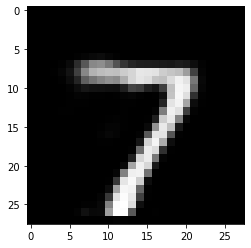

In [16]:
plt.imshow(np.array(X_test_decoded[0], dtype='float').reshape((28, 28)), cmap='gray')
plt.show()

You can see that the image is well reconstructed by the decoder.

##Convolutional Autoencoder
We could add more layers to make the network deeper to improve the performance. But since we are working on images, we could make use of convolutional neural network to improve the quality of compression and decompression.

In [17]:
def make_convolutional_autoencoder():
    # encoding
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(padding='same')(x)
    x = layers.Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(padding='same')(x)
    x = layers.Conv2D( 8, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(padding='same')(x)    
    
    # decoding
    x = layers.Conv2D( 8, 3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(16, 3, activation='relu')(x) # <= padding='valid'!
    x = layers.UpSampling2D()(x)
    decoded = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', 
                        loss='binary_crossentropy')
    return autoencoder
# create a convolutional autoencoder
autoencoder = make_convolutional_autoencoder()

Now, we reshape the image data to the format the convolutional autoencoder expects for training.

In [18]:
# reshape the flattened images to 28x28 with 1 channel
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)
autoencoder.fit(X_train, X_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_valid, X_valid))

Epoch 1/50
465/465 [==============================] - 15s 14ms/step - loss: 0.2205 - val_loss: 0.1562
Epoch 2/50
465/465 [==============================] - 5s 12ms/step - loss: 0.1425 - val_loss: 0.1327
Epoch 3/50
465/465 [==============================] - 5s 12ms/step - loss: 0.1272 - val_loss: 0.1229
Epoch 4/50
465/465 [==============================] - 5s 11ms/step - loss: 0.1200 - val_loss: 0.1180
Epoch 5/50
465/465 [==============================] - 5s 11ms/step - loss: 0.1157 - val_loss: 0.1139
Epoch 6/50
465/465 [==============================] - 6s 13ms/step - loss: 0.1126 - val_loss: 0.1115
Epoch 7/50
465/465 [==============================] - 5s 11ms/step - loss: 0.1103 - val_loss: 0.1096
Epoch 8/50
465/465 [==============================] - 5s 11ms/step - loss: 0.1085 - val_loss: 0.1081
Epoch 9/50
465/465 [==============================] - 5s 11ms/step - loss: 0.1071 - val_loss: 0.1066
Epoch 10/50
465/465 [==============================] - 5s 12ms/step - loss: 0.1059 - val_l

We just want to see the quality of compression/decompression, for which we do not need to build separate encoder and decoder models. So, we simply feed forward test images to see how the restored digits look like.

In [19]:
X_test_decoded = autoencoder.predict(X_test)

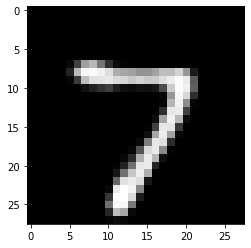

In [20]:
plt.imshow(np.array(X_test_decoded[0], dtype='float').reshape((28, 28)), cmap='gray')
plt.show()

Although not perfect, the restored digit look better than the ones restored by the simple autoencoder.

##What about the Noise Reduction?
Let’s try noise reduction effect using the convolutional autoencoder. We add random noises to the MINST image data and use them as input for training.

In [21]:
def add_noise(x, noise_factor=0.2):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x
    
X_train_noisy = add_noise(X_train)
X_valid_noisy = add_noise(X_valid)
X_test_noisy  = add_noise(X_test)

We train a new autoencoder with the noisy data as input and the original data as expected output.

In [22]:
autoencoder = make_convolutional_autoencoder()
autoencoder.fit(X_train_noisy, X_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_valid_noisy, X_valid))

Epoch 1/50
465/465 [==============================] - 7s 14ms/step - loss: 0.2211 - val_loss: 0.1543
Epoch 2/50
465/465 [==============================] - 6s 14ms/step - loss: 0.1411 - val_loss: 0.1322
Epoch 3/50
465/465 [==============================] - 6s 12ms/step - loss: 0.1281 - val_loss: 0.1241
Epoch 4/50
465/465 [==============================] - 5s 12ms/step - loss: 0.1215 - val_loss: 0.1189
Epoch 5/50
465/465 [==============================] - 5s 12ms/step - loss: 0.1176 - val_loss: 0.1158
Epoch 6/50
465/465 [==============================] - 5s 12ms/step - loss: 0.1146 - val_loss: 0.1135
Epoch 7/50
465/465 [==============================] - 5s 12ms/step - loss: 0.1126 - val_loss: 0.1112
Epoch 8/50
465/465 [==============================] - 5s 12ms/step - loss: 0.1109 - val_loss: 0.1107
Epoch 9/50
465/465 [==============================] - 5s 12ms/step - loss: 0.1096 - val_loss: 0.1085
Epoch 10/50
465/465 [==============================] - 5s 11ms/step - loss: 0.1084 - val_lo

During the training, the autoencoder learns to extract important features from input images and ignores the image noises because the labels have no noises.

Let’s pass the noisy test images to the autoencoder to see the restored images.

In [23]:
X_test_decoded = autoencoder.predict(X_test_noisy)

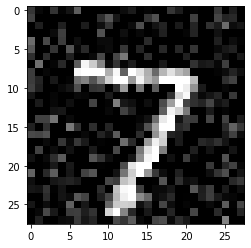

In [24]:
plt.imshow(np.array(X_test_noisy[0], dtype='float').reshape((28, 28)), cmap='gray')
plt.show()

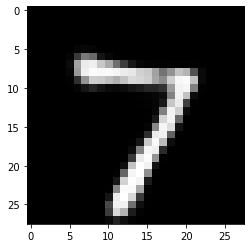

In [25]:
plt.imshow(np.array(X_test_decoded[0], dtype='float').reshape((28, 28)), cmap='gray')
plt.show()

You can see that the noisy image is well recostructed.